# 機械学習の分類の話

分類(Classification)は、教師あり学習の1つで、予測対象はカテゴリなどの離散的な値を予測します。  
具体的には、メールがスパムかどうかや、画像に映っているのがどういった物体か、といったバイナリで表現できる値を予測する場合にモデルを作ります。

基本的に、入力データをベクトル $x$ （例えば `[1, 3, 4, 8]` ）と考えた時に、予測対象のカテゴリ $y$ ( ham/spam )を出力します。  
入力ベクトルは整数や小数のベクトルの場合が多いですが、「晴れ」「雨」などといったカテゴリ情報も適当な数値に変換して扱うことが多いです。  
同様に出力されたカテゴリは、-1や1などの整数で表現することが多いです。

このnotebookでは、分類について以下のモデルを紹介します。

- **パーセプトロン**(Perceptron)
- **ロジスティック回帰**(Logistic Regression)
- **SVM**(Support Vector Machine, サポートベクターマシン)
- **ニューラルネットワーク**(Neural Network)
- **k-NN**(k近傍法, k Nearest Neighbor)
- **決定木**(Decision Tree)
  - **ランダムフォレスト**(Random Forest)
  - **GBDT**(Gradient Boosted Decision Tree)

パーセプトロン、ロジスティック回帰、SVM、ニューラルネットワークの4つは、  
2つのクラスを分類する面（**決定境界**(Dicision Boundary)と言います）を表現する関数を学習します。 
k-NNは最近傍法とも呼ばれ、学習済みのデータから距離が近いデータを元に判断をします。  
決定木、ランダムフォレスト、GBDTは、木構造のルールを学習します。

また、このnotebookでは詳しく扱いませんが、この他にもテキスト分類などでよく使われる  
**ナイーブベイズ**(Naive Bayes)や、音声認識で伝統的に使われてきた**HMM**(Hidden Markov Model)などがあります。  
これらのモデルは、データの背景に隠れた確率分布を推測することで、データをモデル化する手法です。  

それでは、個々のアルゴリズムについて説明しましょう。


## 1. パーセプトロン

<img src="./images/perceptron.png" width=600px />
<p style="text-align: center;">パーセプトロンのイメージ図</p>

 **パーセプトロン** （単純パーセプトロンと呼ぶこともあります）は、  
入力ベクトル（例えば $x$ とします）と  
学習した重みベクトル（例えば $w$ とします）を    
掛けあわせた値を足しあわせて、その値が0以上の時はクラス1、0未満の時はクラス2と分類するというシンプルなモデルです。

重みベクトルを配列 `w` 、入力ベクトルを配列 `x` としてとても簡単な擬似コードで書くとこうなります。

```py
def predict(x, w):
    s = np.dot(x, w)
    if s >= 0:
        return 1
    else
        return -1
```

実際には、

```py
w[0] * 1 + w[1] * x[1] + w[2] * x[2]
```

の合計値が正なのか負なのかでクラスを判断をします。

この例では、データが2次元であるという設定で書いています。  
もちろん、入力ベクトル `x` が3次元以上（ベクトルの要素が3以上)になっても構いません。  
重みベクトル `w` が3つ要素があるのは、 `w[0]` はバイアスと呼ばれる変数 `x[1], x[2]` とは独立な重みを表現しているからです。

この重みベクトル `w` を学習するのが目標です。

### パーセプトロンの特徴、あるいは線形分離可能とは

パーセプトロンの特徴としては、以下のような特徴があります。

- 線形分離可能な問題のみ解ける
- オンライン学習で学習する
- 予測性能はそこそこで、学習は速い
- 過学習には弱い

パーセプトロンは**線形分離可能**(Linearly Separable)な問題のみ解くことができます。  
線形分離可能とは、データをある直線でスパっと2つに分けられるデータのことを言います。

少しコードで説明しましょう。 

以下の2つのセルのコードは、ダミーデータの生成とそのプロットのためのコードです。   
細かい所は気にしなくても良いですが、  
- `df`には直線で分離できる（＝線形分離可能）ダミーデータ
- `df_xor`は直線では分離できない（＝線形分離不可能）ダミーデータ

を格納しているということを覚えておいて下さい。

In [1]:
%matplotlib inline

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
import pandas as pd
import numpy as np
from numpy.random import normal as rnorm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.size'] = 16

def plot_result(clf, clf_name, df):    
    X = df[['x','y']]
    Y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.4, random_state=40)
    n_classes = len(Y.unique())
    cm = plt.cm.RdBu
    plot_colors = "rbym"
    plot_markers = "o^v*"
    plot_step = 0.02
    
    x_min, x_max = X.ix[:, 0].min() - .5, X.ix[:, 0].max() + .5
    y_min, y_max = X.ix[:, 1].min() - .5, X.ix[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))
    
    clf.fit(X_train,y_train)    
    score = clf.score(X_test, y_test)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cm,  alpha=.5)

    # 学習用の点をプロット
    for i, color, m in zip(range(n_classes), plot_colors, plot_markers):
        plt.scatter(X[Y==i].x, X[Y==i].y, c=color, label=i, cmap=cm, marker=m, s=80)

    plt.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                    size=15, horizontalalignment='right')        
    plt.title(clf_name)

In [2]:
# 線形分離可能
N = 50
p1 = pd.DataFrame(np.hstack((rnorm(loc=2.0, scale=0.5, size=(N,1)), 
                              rnorm(loc=2.0, scale=0.5, size=(N,1)))),
                   columns=['x','y'])
p1['label'] = 0
p2 = pd.DataFrame(np.hstack((rnorm(loc=1.0, scale=0.5, size=(N,1)), 
                              rnorm(loc=1.0, scale=0.5, size=(N,1)))),
                   columns=['x','y'])
p2['label'] = 1
df = pd.concat([p1, p2])

# XORパターン（線形分離不可能）
N = 50
p1 = pd.DataFrame(np.hstack((rnorm(loc=1.0, scale=1.0, size=(N,1)), 
                              rnorm(loc=1.0, scale=1.0, size=(N,1)))),
                   columns=['x','y'])
p1['label'] = 0
p2 = pd.DataFrame(np.hstack((rnorm(loc=-1.0, scale=1.0, size=(N,1)), 
                              rnorm(loc=1.0, scale=1.0, size=(N,1)))),
                   columns=['x','y'])
p2['label'] = 1
p3 = pd.DataFrame(np.hstack((rnorm(loc=-1.0, scale=1.0, size=(N,1)), 
                              rnorm(loc=-1.0, scale=1.0, size=(N,1)))),
                   columns=['x','y'])
p3['label'] = 0
p4 = pd.DataFrame(np.hstack((rnorm(loc=1.0, scale=1.0, size=(N,1)), 
                              rnorm(loc=-1.0, scale=1.0, size=(N,1)))),
                   columns=['x','y'])
p4['label'] = 1
df_xor = pd.concat([p1,p2,p3,p4])

それでは、準備ができたのでパーセプトロンがどのようにデータを分離するのかを見てみましょう。

次のコードでプロットされる、1つ目のデータは単純に直線で分離ができる（線形分離可能）なデータ、  
2つ目がいわゆる[XOR](https://ja.wikipedia.org/wiki/%E6%8E%92%E4%BB%96%E7%9A%84%E8%AB%96%E7%90%86%E5%92%8C)と言われる線形分離不可能なデータです。  
(図右下の数字は正解率です)

このように、パーセプトロンは直線で分類することしかできないので、上の図しか分類できていないですね。

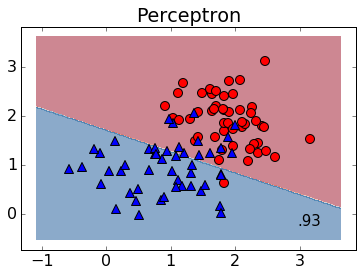

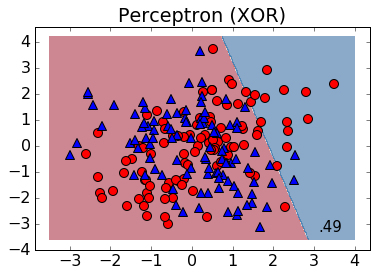

In [54]:
clf = Perceptron()

plot_result(clf, 'Perceptron', df)
plt.show()
plot_result(clf, 'Perceptron (XOR)', df_xor)

この分類する直線を少し専門的な言い方で**超平面**(Hyperplane)と言います。（ここでの意味合いとしては決定境界と同じです）  
二次元の時は直線ですが、三次元だと平面になります。高次元空間での平面ということで超平面と言います。

逆に２つ目の図のように、直線で分けられないデータのことを線形分離できないので線形分離不可能（あるいは非線形線形分離可能）なデータといいます。
よく例としてあげられるのは排他的論理和(XOR)のデータが挙げられます。

２つ目の図のようにXORは、原点を中心として右上と左下が1つのクラス、右下と左上が1つのクラスになるようにデータが存在します。  
そのため、1本の直線を引くだけでは2つのクラスを適切に分離することはできません。  
この、「1本の直線を引くだけで2つのクラスを分離できない」のが線形分離不可能ということです。

パーセプトロンは非線形な分離はできないので、決定境界は直線になっています。  
なので、XORは分離することができていませんね。

### 学習するということ

では、どうやって適切な重みを推定すればいいのでしょうか？  
真の値とのズレである誤差を表す関数を**損失関数**(Loss Function}または誤差関数(Error Function)といいます。

例えば、誤差の二乗を損失関数とすると、

$損失関数=(真の値-予測値)^2$

となります。

以下に二乗誤差の図の例を示します。

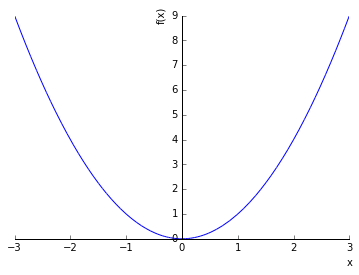

In [46]:
from sympy.plotting import plot
from sympy import *

x, y = symbols("x y")
f = x **2
plot(f, (x, -3, 3))

実際にはパーセプトロンの損失関数は、`w`が重みベクトル、`x`が入力ベクトル、`y`の正解ラベル（1か-1）としたとき、

```py
max(0, -ywx)
```

となります。

この損失関数を**ヒンジ損失**(Hinge Loss)といいます。  
次の図を見るとわかりますが、蝶つがい（ヒンジ）のように見えることからこの名前が付いています。

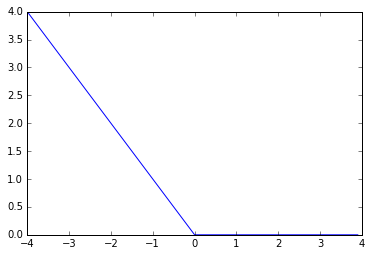

In [48]:
x = np.arange(-4, 4, 0.1)
y = np.maximum(0, -x)
fig = plt.plot(x, y)

さらに、パーセプトロンの目的関数は

$目的関数=損失関数$

となり、目的関数を最小化することが、誤りの少ない最適な分類ができる状態になると言えます。  
こうなる重みを得ることが「学習をする」ということになります。

### 確率的勾配法で重み学習する


では、どのように重みを推定すればよいのでしょうか。  
重みの最適化には**確率的勾配降下法**(Stocastic Gradient Descent, SGD)と呼ばれる方法がよく使われます。  

この方法では、目的関数の山の上から少しずつ谷に向かってで降りることで、最適な重みを得ることができます。  
実際には、谷の場所は直接は見えない状態で周囲の限られた範囲しか見えません。  

次の図での白丸のように、坂の傾きが大きい下り方向に向かって一歩一歩矢印の先進んでいき、重みを修正します。  
そして、目的関数が最も小さいところにたどり着けば、その重みが最適な値となります。（これを解が収束すると言います。）

<img src="./images/sgd.png" width=600px />

ちなみに、山を逆にすると目的関数を最大化することになるので、山登り法とも呼ばれます。

どれくらいの幅で修正するかのパラメータを学習率(Learning Rate)と言います。  
修正する幅は $学習率×山の傾き$ で決まります。  
学習率が大きい値だと速く収束するかもしれませんが、谷を行き過ぎて最適な解に収束しない場合もあります。  
学習率が小さい場合は、収束するまでに必要な繰り返し回数が増えるため、学習時間が長くなります。  

シンプルな方法では学習率が固定のまま学習しますが、後述するニューラルネットワークではこの設計が肝になってくることもあり、  
動的に変化させる様々な工夫が提案されています。

### 掛けあわせた値を活性化関数にかける

さて、パーセプトロンの予測値は重みベクトルと入力ベクトルを掛けた結果の正負で判定しましたね。  
これは掛けあわせた結果を、**ステップ関数**(Step Function)という関数に通しているとも言えます。  
ステップ関数とは次の図のような関数で、入力の値を+1または-1にしてくれます。  
特に、パーセプトロンにおけるステップ関数のような、出力値を非線形変換する関数を**活性化関数**(Activation Function)と呼びます。  

通常のステップ関数は0か1を出力しますが、パーセプトロンによる2クラス分類は、  
計算のしやすさから2つのクラスを-1、+1とすることが多いです。

<img src="./images/step_func.png" width=600px />

パーセプトロンは、その後の様々なアルゴリズムに影響を与えた、歴史的に重要なアルゴリズムです。

引き続き、パーセプトロンの仲間のアルゴリズムについて学んでいきましょう。

## ロジスティック回帰

<img src="./images/logistic_regression.png" width=600px />
<p style="text-align: center;">ロジスティック回帰のイメージ図</p>

**ロジスティック回帰** は、回帰という名前とは裏腹に分類のためのモデルです。  
イメージ図はパーセプトロンとよく似ていますが、活性化関数が少し違います。

パーセプトロンとよく似ていますが、以下のような特徴があります。

- 出力とは別に、その出力のクラスに所属する確率値が出せる
- 学習はオンライン学習でもバッチ学習でも可能
- 予測性能はまずまず、学習速度は速い
- 過学習を防ぐための正則化項が加わっている

特に出力の確率値が出せるという特徴のため、広告のクリック予測にもよく使われています。

ロジスティック回帰は、パーセプトロンと同じく線形分離可能な分類器のため、決定境界は直線になります。  
以下に、実際の分類例を示します。

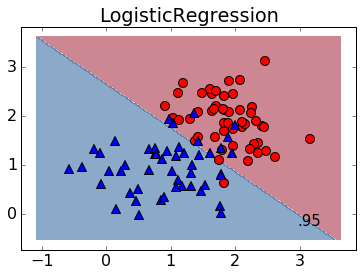

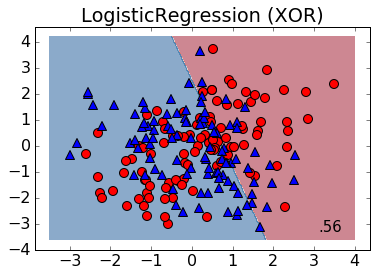

In [55]:
clf = LogisticRegression()
plot_result(clf, 'LogisticRegression', df)
plt.show()
plot_result(clf, 'LogisticRegression (XOR)', df_xor)

### パーセプトロンとの違い

パーセプトロンとの違いは、

- 活性化関数がシグモイド関数(Sigmoid Function)（ロジスティック・シグモイド関数(Logistic sigmoid funcrtion)とも言います）であること
- 損失関数が交差エントロピー損失(Cross-entropy Loss)であること
- **正則化項**(Regularization Term)（または**罰則項**(Penalty Term)とも呼ばれます）が加わっているためパーセプトロンより過学習を防ぎやすいこと
- オンラインでもバッチでも学習可能なこと

が挙げられます。

### シグモイド関数

シグモイド関数は以下に示すような形状をしています。  
入力が0の時は0.5をとり、値小さくなるほど0に、大きくなるほど1に近づく関数です。  
ちなみに、シグモイド関数を一般化したものがロジスティック関数と呼ばれており、ロジスティック回帰の由来となっています。

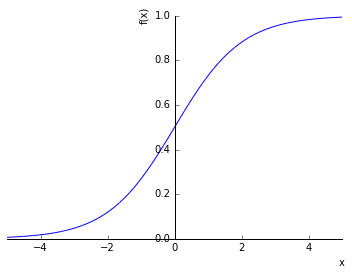

In [47]:
f = 1 / (1+exp(-x))
plot(f, (x, -5, 5))

### 正則化項が決定境界をなめらかにする

**正則化**(Regularization)は、学習時にペナルティを与えることで決定境界をなめらかにする働きを持ちます。  
入力データに対して最適化する際に正則化項を加える事で、既知のデータの影響を受けすぎないようにします。  
つまり、未知のデータに対するあそびを作ることができるのです。

既知のデータに対して最適化をし過ぎると、ノイズののった変なデータに対しても対応しようと頑張りすぎてしまいます。  
こういったデータに対しても、正則化をすることで強く影響を受けすぎないことが可能となります。

正則化項を加えると目的関数は以下のように表現できます。

$目的関数 = 損失関数 + 正則化項$

この目的関数を最小化するパラメータを推定することで、ロジスティック回帰を学習できます。
パーセプトロンと同じく確率的勾配降下法を使うことで最適化できます。

## SVM

<img src="./images/svm.png" width=600px />
<p style="text-align: center;">SVMのイメージ図</p>


SVMは、分類問題を解くときに非常に良く利用されているモデルです。  
パーセプトロンを拡張したモデルと考えることができ、線形分離不可能な問題も解くことができます。  
様々なアルゴリズムやライブラリが開発されており、高速な学習ができます。  

以下のような特徴があります。

-  **マージン最大化** をすることで、なめらかな超平面を学習できる
- カーネル(Kernel)と呼ばれる方法を使い、非線形なデータを分離できる
- 線形カーネルなら次元数の多い疎なデータも学習可能
- バッチ学習でもオンライン学習でも可能

損失関数はパーセプトロンと同じく、ヒンジ損失を使います。  
厳密にはパーセプトロンとは、横軸との交点の場所が違います。  
グラフとして書くと以下のようになります。

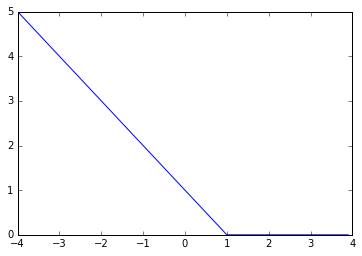

In [49]:
x = np.arange(-4, 4, 0.1)
y = np.maximum(0, 1-x)
plt.plot(x, y)

### SVMの特徴その1：マージン最大化

SVMの特徴は大きく2つあります。

1つ目の特徴は、マージン最大化をすることで、正則化項と同じように過学習を抑える事ができます。

<img src="./images/svm.png" width=600px />
<p style="text-align: center;">SVMのイメージ図（再掲）</p>


マージン最大化は、イメージ図のように超平面をどのように引けば、2クラスそれぞれ最も近いデータ（これをサポートベクターと言います）までの距離が最大化できるかを考えます。  
サポートベクターから等距離となるように超平面を引けば、未知のデータに対して余裕のある超平面が得ることができます。

サポートベクターと超平面までの距離（これを**マージン**といいます）が  
最大になるような超平面の引き方を決めることで、既知のデータに対して最もあそびが生まれます。  
このおかげで、データに特化し過ぎない余裕のある決定境界を得ることが出来ます。  

最適化手法は様々あり詳細は割愛しますが、バッチ学習のためのアルゴリズムもオンライン学習も両方あります。  

### SVMの特徴その2：カーネルトリック

2つ目の特徴は、カーネルと呼ばれるテクニックです。

これは線形分離不可能なデータでも、カーネルと呼ばれる関数を使ってデータをより高次元空間に変換することで、  
線形分離可能にするという方法です。  
以下のイメージ図を見てみると、1次元では線形分離できなかったのが、2次元に変換をすることで、線形分離可能になっています。  

<img src="./images/kernel.png" width=600px />
<p style="text-align: center;">カーネルトリックのイメージ</p>

カーネルには、
- **線形カーネル**(Linear Kernel)
- **多項式カーネル**(Polynomial Kernel)
- **RBFカーネル**(Radial Basis Function Kernel, 動的基底関数カーネル)

などがあります。  

次の４つの図に、線形カーネルとRBFカーネルの時の決定境界を示します。  
特に、線形カーネル(XOR)とRBFカーネル(XOR)の図を見比べるとわかるように、RBFカーネルの方がXORに対して適切に分離できているのがわかります。

線形カーネルは処理の速さから主にテキストなどの高次元で疎なベクトルのデータに、RBFカーネルは画像や音声信号などの密なデータによく使われます。

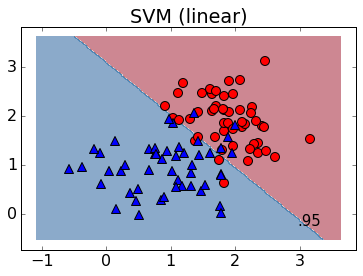

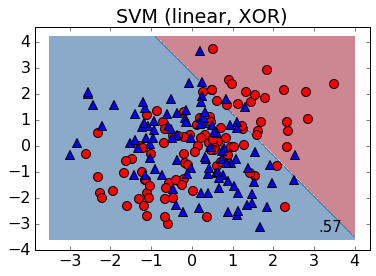

In [59]:
clf = SVC(kernel='linear')
plot_result(clf, 'SVM (linear)', df)
plt.show()
plot_result(clf, 'SVM (linear, XOR)', df_xor)

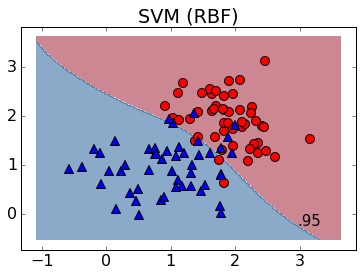

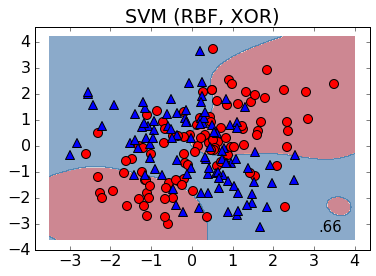

In [60]:
clf = SVC(kernel='rbf')
plot_result(clf, 'SVM (RBF)', df)
plt.show()
plot_result(clf, 'SVM (RBF, XOR)', df_xor)

## ニューラルネットワーク

<img src="./images/nn.png" width=600px />
<p style="text-align: center;">ニューラルネットワークのイメージ図</p>


**ニューラルネットワーク**(Neural Network)は多層パーセプトロンとも呼ばれ、パーセプトロンを1つのノードとして階層上に重ねたもののことです。  
脳の神経モデルを模倣しているためこの名前になっています。

ニューラルネットワークはいろいろな形状がありますが、一番基本的な3階層のフィードフォワード型ニューラルネットワークを考えます。  
入力層、中間層、出力層という順番に入力と重みを掛けあわせて計算していき、出力層に分類したいクラスだけノードを用意します。  
入力層、出力層の数に応じて中間層（隠れ層とも言います）の数を用意します。

活性関数には、初期はステップ関数が、その後シグモイド関数が良く利用されてきました。  
近年では深層学習では**ReLU**(Rectified Linear Unit)が性能が良いためよく使われています。  　　
ReLUは以下のようなグラフになります。

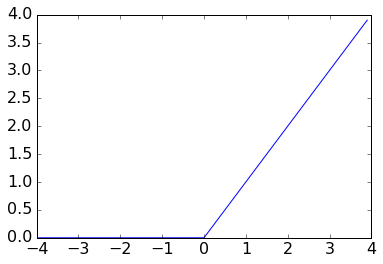

In [3]:
x = np.arange(-4, 4, 0.1)
y = np.maximum(0, x)
fig = plt.plot(x, y)

ニューラルネットワークの場合パーセプトロンとは異なり、非線形関数を活性化関数として利用したものを多段に重ねるため、決定境界は直線でないものも描けます。

ニューラルネットワークの決定境界は、詳しくは西尾泰和さんの[TensorFlow Playgroundの解説記事](http://d.hatena.ne.jp/nishiohirokazu/20160414/1460602667)を見ると良いでしょう。  
（執筆当時はscikit-learnにNNの実装がなかった...）

### ニューラルネットワークの学習法

フィードフォワード型のニューラルネットワークは、**誤差逆伝播法**(バックプロパゲーション, Backpropagation)と呼ばれる方法で学習します。  
ランダムに初期化した重みの値を使って出力値をネットワークの順方向に計算し、  
計算した値と正解となる値との誤差をネットワークの逆方向に計算して重みを修正します。  
そして、重みの修正量が規定値以下になるか決められたループ回数を繰り返したら学習を打ち切ります。

### ニューラルネットワークの特徴

ニューラルネットワークには以下のような特徴があります。

- 非線形なデータを分離できる
- 学習に時間がかかる
- パラメータの数が多いので、過学習しやすい
- 重みの初期値に依存して、局所最適解にはまりやすい

ニューラルネットワークの中間層の層を増やすと、誤差逆伝播法では学習ができない問題があります。  
それを解決して深いネットワークも学習できるようにしたのが深層学習です。

## k-NN(k近傍法)

k-NN(k近傍法)は、未知のデータのクラスを近くの既知データのクラスの多数決で決めるという、最近傍探索のアルゴリズムの1つです。  
kは投票する個数のことを意味し、 $k=3$ のときはデータに最も近い3点のうち、得票数が多いクラスに所属しているとみなします。  

<img src="./images/knn.png" width=600px />
<p style="text-align: center;">k-NNのイメージ図</p>



イメージ図の例を見てみましょう。  
新しいデータである□が、○と△のどちらのクラスかということを考えます。  
□の周囲3つのデータを見ると○になることがわかります。  
もちろん、kの数を変えると所属するクラスは容易に変わります。  

kを3としてダミーデータで分類をした図が以下の２つになります。  
XORの例を見てもわかるように、決定境界は直線にはなりません。

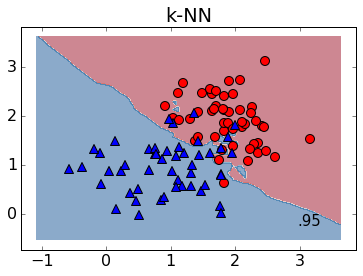

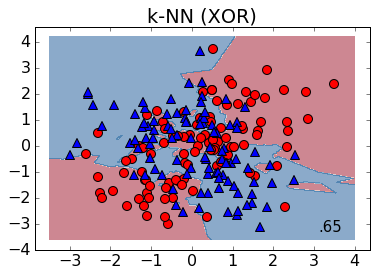

In [56]:
clf = KNeighborsClassifier(3)
plot_result(clf, 'k-NN', df)
plt.show()
plot_result(clf, 'k-NN (XOR)', df_xor)

### k-NNの特徴

k-NNには以下のような特徴があります。

- インクリメンタルに1つずつ学習する
- 単純な方法だと全データとの距離計算をする必要があるため、予測計算に時間が掛かる
- kの数によるがそこそこの予測性能

### kの決め方

kの数は交差検証で決めます。  
この時、どのデータが「近い」のかというのを決めるためには、「距離」を定義する必要があります。

多く用いられるのは2つの点を結んだ直線の長さであるユークリッド距離(Euclidean Distance}ですが、分散を考慮する**マハラノビス距離**(Mahalanobis Distance)が用いられることも有ります。  
ユークリッド距離は、点の座標を表すベクトル$a$とベクトル$b$があったとき、

```py
np.sqrt(sum(x - y)**2 for x, y in zip(a, b))
```

で求めることが出来ます。  
（実際には、NumPyを使って@<code>{np.linalg.norm(a - b)}で求めたほうが高速です。）

### k-NNの使いドコロ

自然言語処理のときなど、疎なデータの場合は次元の呪いのため予測性能がでないことが多いです。　　
こうしたときには、後述する次元削減手法で次元圧縮をすると性能が改善することが知られています。

k-NNはシンプルでな手法のため、気軽に試すのには良い方法です。　　
また、距離さえ定義できれば応用が効くので、例えばElasticsearchなどの全文検索エンジンのスコアを距離とみなしてk-NNを使うなどもできます。　　
計算時間がかかる問題については、近似的に近傍探索をするなどいくつかの手法がでています。

## 決定木、ランダムフォレスト、GBDT

<img src="./images/decision_tree.png" width=600px />
<p style="text-align: center;">決定木のイメージ図</p>


決定木は、木の根から順番に条件分岐をたどっていき、葉に到達すると予測結果を返すモデルです。  
**不純度**(Impurity)と呼ばれる基準を使って、分割する前と後でできるだけ違うクラスが混ざらなくなるように分岐条件を学習していきます。  
具体的には**情報ゲイン**(Information Gain)や**ジニ係数**(Gini coefficient)などの基準を不純度として使い、不純度が下がるようにデータを分割します。  
決定木を使うことで、データからうまく分類できるようなIF-THENルールのツリーを、イメージ図のように得ることができるのです。


### 決定木の特徴

決定木の特徴をまとめると、以下のようになります。

- 学習したモデルを人間が見て解釈しやすい
- 入力データの正規化がいらない
- カテゴリー変数や欠損値などを入力しても内部で処理してくれる
- 特定の条件下では過学習しやすい傾向にある
- 非線形分離可能だが、線形分離可能な問題は不得意
- クラスごとのデータ数に偏りのあるデータは不得意
- データの小さな変化に対して結果が大きく変わりやすい
- 予測性能はまずまず
- バッチ学習でしか学習できない

決定木の大きな特徴としては、学習したモデルを可視化して解釈しやすいという点があげられます。  
これは、学習結果としてIF-THENルールが得られるため、工場のセンサー値から製品の故障を予測したい場合、どのセンサーが異常の原因なのかといったように、  
この分類結果に至った条件が得られることが求められるシーンには有効でしょう。  

パーセプトロンやロジスティック回帰とは異なり、線形分離不可能なデータも分類できます。  
一方で線形分離可能な問題はそこまで得意ではありません。

また、データを条件分岐で分けていくという性質上、木の深さが深くなると学習に使えるデータ数が少なくなるため、過学習しやすくなる傾向にあります。  
これについては、木の深さを少なくしたり**枝刈り**(剪定, pruning)することである程度防ぐことが出来ます。  
特徴の数が多い時も過学習しやすくなるため、事前に次元削減や特徴選択をしておくと良いでしょう。  

ダミーデータに対する決定境界を見ても、線形分離可能な単純な例の方が過学習気味になっているのがわかります。

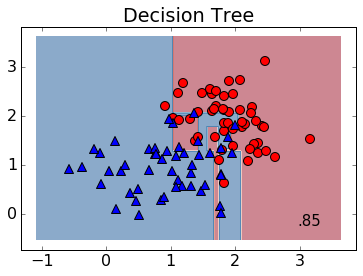

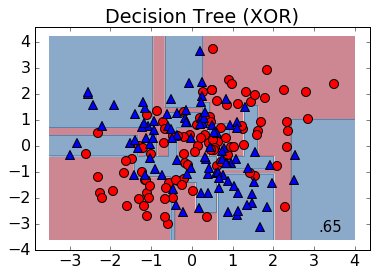

In [57]:
clf = DecisionTreeClassifier()
plot_result(clf, 'Decision Tree', df)
plt.show()
plot_result(clf, 'Decision Tree (XOR)', df_xor)

### 決定木を複数作って統合する、ランダムフォレスト

決定木を応用した手法に、**ランダムフォレスト**(Random Forest)や**Gradient Boosted Decision Tree**(GBDT)があります。

ランダムフォレストは、利用する特徴量の組み合わせを色々用意して、性能がよかった学習器複数の予測結果を多数決で統合します。  
複数の木を独立に学習できるため並列で学習できます。  
また、決定木の枝刈りをしないため主なパラメータは2つと後述するGBDTと比べて少ないですが、過学習しやすい傾向にあります。  

予測性能は決定木より高く、パラメータ数が少ないためチューニングも比較的簡単で手頃です。  
決定境界を見てもわかるように、決定木ベースのアルゴリズムのため傾向は似ています。


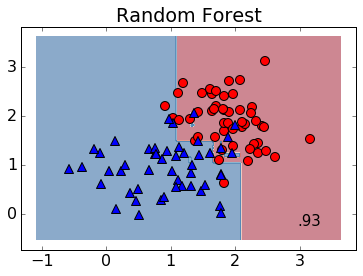

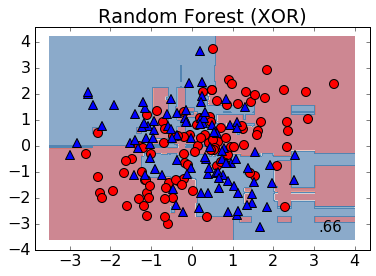

In [58]:
clf = RandomForestClassifier()
plot_result(clf, 'Random Forest', df)
plt.show()
plot_result(clf, 'Random Forest (XOR)', df_xor)

### 直列的に複数の木を学習するGBDT

ランダムフォレストが並列的に学習して予測結果を利用するのに対して、  
GBDTはサンプリングしたデータに対して直列的に浅い木を学習していく勾配ブースティング法(Gradient Boosting)を使うアルゴリズムです。

予測した値と実際の値のズレを目的変数として考慮することで、弱点を補強しながら複数の学習器が学習されます。
直列で学習するため時間がかかること、ランダムフォレストと比べてもパラメータが多いためチューニングにコストがかかりますが、予測性能はランダムフォレストよりも高いです。  

[XGBoost](https://github.com/dmlc/xgboost)という高速なライブラリが出たこともあり大規模なデータでも処理しやすく、コンペサイトのKaggleでも人気です。  
特にXGBoostは確率的な最適化をしているため、大規模データにも高速に処理できます。

### アンサンブル学習とは

ランダムフォレストやGBDTのように、複数の学習結果を組み合わせる手法を**アンサンブル学習**(Ensemble Learning)といいます。
アンサンブル学習は通常、ロジスティック回帰やルールが1つだけの決定木などの  
シンプルな学習器（弱学習器(Week Learner)といいます）を複数組み合わせて学習をします。

単純な決定木は、データの追加を行うと学習結果が大きく変わるのに対して、ランダムフォレストなどは学習結果が安定しやすくなるといったメリットもあります。
また、予測性能もアンサンブルをしたほうがより良くなることが知られています。

## 参考文献

- http://scikit-learn.org/stable/auto_examples/linear_model/plot_sgd_loss_functions.html
-  [jgbos's notebook](http://nbviewer.jupyter.org/github/jgbos/iPython-Notebooks/blob/master/Comparing%20machine%20learning%20classifiers%20based%20on%20their%20hyperplanes%20or%20decision%20boundaries.ipynb) 
- http://scikit-learn.org/dev/auto_examples/neural_networks/plot_mlp_alpha.html